## Конфигурация модели

### `target`
Описание таргета модели.

- `span`: горизонт прогноза
- `threshold`: ожидаемый рост на горизонте

### `learn`
Описание данных для обучения.

- `learn.from_dt`, `leart.to_dt`: интервал для обучения
- `learn.depth`: глубина фичей

### `search`

Описание процесса поиска гиперпараметров и отбора фичей.

- `n_iter`: количество итераций для поиска гиперпараметров
- `metric.n_blocks`: количество блоков
- `features.min`, `features.max`: целевое количество фичей (интервал)
- `metric.std_pentalty`: коэффициент для занижения метрики при большой вариации скоров
- `metric.std_pentalty`: коэффициент для перекоса метрики в сторону более свежих блоков


### Пример:
```yaml
ticker: GAZP-702

target:
  span: 7
  threshold: 0.025

learn:
  from_dt: 2017-01-01
  to_dt: 2022-12-31
  depth: 28

search:
  n_iter: 20
  n_blocks: 10
    
  features:
    min: 20
    max: 60

  metric:
    std_penalty: 0.001
    weight_offset: 0.75
```


In [1]:
%%writefile ./data/models/test-01.yaml

ticker: GAZP-702

target:
  span: 7
  threshold: 0.025

learn:
  from_dt: 2019-01-01
  to_dt: 2022-12-31
  depth: 28

search:
  n_iter: 40
  n_blocks: 10
    
  features:
    min: 10
    max: 20

  metric:
    std_penalty: 0.001
    weight_offset: 0.75

Overwriting ./data/models/test-01.yaml


In [2]:
import sys
import datetime
import json
import yaml

import operator as op
from functools import wraps
from itertools import chain, groupby
from jsonschema import Draft202012Validator
from yamlinclude import YamlIncludeConstructor
from pathlib import Path
from tqdm.auto import tqdm
from typing import Type

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier


from ad_hoc_utils.common.config import *
from ad_hoc_utils.common.db import *
from ad_hoc_utils.common.f import *
from ad_hoc_utils.ml.data_preparation import df_to_parquet, df_from_parquet, idx_to_labels, NumpyEncoder
from ad_hoc_utils.ml.data_preparation import extract
from ad_hoc_utils.ml.data_preparation import fetch_data
from ad_hoc_utils.ml.model_selection import *
from ad_hoc_utils.ml.models import *
import ad_hoc_utils.ml.data_preparation as dataprep

import invest.features
from invest.common import *
from invest.features.common import *
from invest.models.common import *

In [3]:
import ipywidgets as widgets

In [4]:
import logging

logging.basicConfig(
    format = '%(asctime)s %(levelname)-8s %(message)s',
    level = logging.INFO,
    datefmt = '%Y-%m-%d %H:%M:%S')

# 1. Чтение конфига модели

In [5]:
import argparse
from argparse import ArgumentParser

def common_init_args_parser(parser):
    parser.add_argument(
        '--data-dir',
        default = './data', type = str,
        help = 'directory with data')

    parser.add_argument(
        '--dry-run',
        default = False, action = 'store_true',
        help = 'do not write anything')

    parser.add_argument(
        '-m', '--model',
        type = str, required = True,
        help = 'model name')
    
    parser.add_argument(
        '--n-jobs',
        default = 8, type = int,
        help = 'model name')
    
    return parser


def search_init_args_parser(parser):
    return parser

In [6]:
parser = common_init_args_parser(ArgumentParser())
subparser = parser.add_subparsers(dest = 'which')

search_init_args_parser(subparser.add_parser('search'));

In [7]:
args = _c(parser.parse_args, L.split(' '))('--dry-run -m test-01 search')

data_dir = Path(args.data_dir)
assert data_dir.exists(), 'data directory does not exist'

cfg = from_yaml(data_dir / 'models' / (args.model + '.yaml'), schema_path = None)

datasource = dict(type = 'file', base_dir = data_dir)

data_params = dict(
    snapshot_dt_col = 'snapshot_dt',
    
    min_snapshot_dt = datetime.datetime.combine(
        cfg['learn']['from_dt'] - datetime.timedelta(days = cfg['learn']['depth']),
        datetime.time.min),
    
    max_snapshot_dt = datetime.datetime.combine(
        cfg['learn']['to_dt'] + datetime.timedelta(days = 1 + cfg['target']['span']),
        datetime.time.max),
        
    ticker = cfg['ticker'])


n_weeks_depth = cfg['learn']['depth'] // 7
n_weeks_span = cfg['target']['span'] // 7

display(cfg)

{'ticker': 'GAZP-702',
 'target': {'span': 7, 'threshold': 0.025},
 'learn': {'from_dt': datetime.date(2019, 1, 1),
  'to_dt': datetime.date(2022, 12, 31),
  'depth': 28},
 'search': {'n_iter': 40,
  'n_blocks': 10,
  'features': {'min': 10, 'max': 20},
  'metric': {'std_penalty': 0.001, 'weight_offset': 0.75}}}

# 2. Прогрузка данных

`df_intervals` -- данные по котировкам за каждый час (o, c, h, l, v). `snapshot_dt` -- время закрытия интервала.

`df_sessions` -- разметка торговых сессий. `session_dt` -- день начала сессии.

Торговая сессия начинается утром и заканчивается вечером того же дня, возможно, в 00:00 следующего. В середине дня допускаются перерывы в торгах.

В модель пойдут данные, сагрегированные до сессии: 1 сессия, одна строка в датасете.

In [8]:
df_intervals = (
    fetch_data(datasource, 'quotes/{ticker}', data_params)
    .sort_values('snapshot_dt')
    .reset_index(drop = True))

df_intervals = df_intervals.merge(
    extract('session_rn', df_intervals, ['snapshot_dt'], min_delimiter_span = 8*60*60),
    on = ['snapshot_dt'],
    how = 'inner')

df_sessions = extract('session_dt', df_intervals, ['session_rn'])
df_intervals = df_intervals.merge(df_sessions, on = ['session_rn'], how = 'inner')

In [9]:
display(df_intervals.head())

c       h       l       o         snapshot_dt        v  session_rn  \
0  163.50  164.94  163.12  164.92 2018-12-04 11:00:00  3317730           1   
1  164.92  165.00  163.50  163.56 2018-12-04 12:00:00  3437030           1   
2  163.78  164.98  163.60  164.95 2018-12-04 13:00:00  2847440           1   
3  163.64  163.87  163.30  163.74 2018-12-04 14:00:00  1662330           1   
4  163.90  164.15  163.47  163.61 2018-12-04 15:00:00  1351280           1   

  session_dt  
0 2018-12-04  
1 2018-12-04  
2 2018-12-04  
3 2018-12-04  
4 2018-12-04

In [10]:
display(df_sessions.head())

session_rn session_dt
0           1 2018-12-04
1           2 2018-12-05
2           3 2018-12-06
3           4 2018-12-07
4           5 2018-12-10

In [11]:
df_metadata = (
    df_sessions
    .merge(extract('past_metadata', df_sessions, ['session_rn'], n_weeks = n_weeks_depth), on = 'session_rn', how = 'left')
    .merge(extract('future_metadata', df_sessions, ['session_rn'], n_weeks = n_weeks_span), on = 'session_rn', how = 'left')
    .merge(extract('var', df_intervals, ['session_rn'], n_weeks = n_weeks_depth, columns = ['h']), on = 'session_rn', how = 'left')
    .merge(extract('adf', df_intervals, ['session_rn'], n_weeks = n_weeks_depth), on = 'session_rn', how = 'left'))

In [12]:
idx = (df_metadata['future_metadata.f_abnormal'] | df_metadata['past_metadata.f_abnormal'])
logging.info('n_rows: {} -> {} ({:0.1%} data will be removed)'.format(len(idx), (~idx).sum(), idx.mean()))

df_metadata = df_metadata[~idx].reset_index(drop = True)
df_sessions = df_sessions[~idx].reset_index(drop = True)

2023-06-05 16:29:50 INFO     n_rows: 1015 -> 489 (51.8% data will be removed)


# 3. Сегментация торговых сессий

В словаре `quantiles` мы прописываем верхнюю и нижнюю границы столбцов из `df_metadata` (в квантилях). Название ключа записи должно совпадать с названием столбца.

На выходе для каждого элемента с ключом `column_name` в датафрейм добавится столбец `column_name_segment`, принимающий 3 значения:
- 0 -- переменная `column_name` попала в интервал между квантилями из словаря
- 1 -- переменная `column_name` попала в более широкий интервал (в 1.5 раза шире, чем в предыдущей группе)
- 2 -- всё остальное (выбросы)

In [13]:
quantiles = dict(
    h_var = (0, 0.45),
    adf_pvalue = (0, 0.5))

In [14]:
segments = {k: tuple(df_metadata[k].quantile(qs)) for k, qs in quantiles.items()}
display(segments)

df_metadata = (
    df_metadata
    .merge(extract('stability_segments', df_metadata, ['session_rn'], segments = segments), on = 'session_rn', how = 'left'))

segment_cols = list(df_metadata.columns[-len(segments):])

{'h_var': (4.495299762041336, 36.040995050940566),
 'adf_pvalue': (7.408633238624371e-05, 0.5709630995853069)}

In [15]:
display(pd.crosstab(df_metadata[segment_cols[0]], df_metadata[segment_cols[1]]))

adf_pvalue_segment    0    1
h_var_segment               
0                    88  132
1                   135  104
2                    22    8

В `idx_segment` фиксируем сегмент, на котором обучаем модель:

In [16]:
idx_segment = ((df_metadata['h_var_segment'] <= 1) & (df_metadata['adf_pvalue_segment'] <= 1))
logging.info(f'n_rows: {idx_segment.sum()}')

2023-06-05 16:29:51 INFO     n_rows: 459


# 4. Целевая переменная

In [ ]:
df_metadata = (
    df_metadata
    .merge(extract('target', df_intervals, ['session_rn'], n_weeks = n_weeks_span, threshold = cfg['target']['threshold']), on = 'session_rn', how = 'left'))

target_col = df_metadata.columns[-1]

In [ ]:
df_metadata.groupby(segment_cols)[target_col].mean().reset_index().pivot(index = segment_cols[0], columns = segment_cols[1])

In [ ]:
ys = df_metadata[idx_segment][target_col].reset_index(drop = True).astype(int)
display(ys.head())

### research zone

In [29]:
from invest.features.common import _mk_future_window_params

In [30]:
@extract.register
def extract_relative_change(df, primary_key_cols, *, n_weeks):
    c = f'rel_change'

    return extend(
        (df
         .sort_values('snapshot_dt')
         .groupby(primary_key_cols)['c'].last()
         .reset_index()
         .merge(
             roll_over_intervals(
                 df, primary_key_cols, _mk_future_window_params(n_weeks),
                 dict(h_max = lambda r: r['h'].max())),
             on = primary_key_cols,
             how = 'inner')),
        {c: lambda r: (r['h_max']/r['c'] - 1)})[[*primary_key_cols, c]]


2023-06-05 16:36:31 WARNING  overwriting handler for extract::relative_change


In [33]:
df = df_metadata[['session_rn']].merge(
    extract('relative_change', df_intervals, ['session_rn'], n_weeks = n_weeks_span), on = 'session_rn', how = 'left')

<AxesSubplot: >

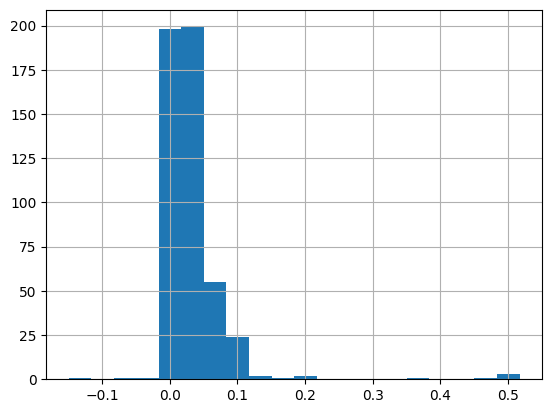

In [36]:
df['rel_change'].hist(bins = 20)

In [37]:
df['rel_change'].quantile([0.25, 0.5, 0.75])

0.25    0.009422
0.50    0.021887
0.75    0.040995
Name: rel_change, dtype: float64

# 5. Предикторы

In [ ]:
df_tsfresh_features = fetch_data(
    datasource,
    'features/{ticker}-tsfresh-{depth}',
    data_params | dict(
        snapshot_dt_col = 'session_dt',
        base = df_sessions[idx_segment][['session_dt']],
        depth = cfg['learn']['depth']))

In [ ]:
xs = (
    df_metadata[idx_segment][['session_dt']]
    .merge(df_tsfresh_features, on = 'session_dt', how = 'left')
    .reset_index(drop = True)
    .drop(columns = ['session_dt'])
    .fillna(0)
    .reset_index(drop = True).astype(int))

display(xs.head())

### research zone

In [44]:
@extract.register
def extract_weekdays(df, primary_key_cols, *, names = ['mon', 'tue', 'wed', 'thu', 'fri']):
    
    mapping = dict(
        mon = 0,
        tue = 1,
        wed = 2,
        thu = 3,
        fri = 4,
        sat = 5,
        sun = 6)

    data = []
    data.append(df[primary_key_cols])
    
    for k in names:
        data.append((df['session_dt'].dt.weekday == mapping[k]).rename(f'weekday_is_{k}'))
        
    return pd.concat(data, axis = 1)

2023-06-05 16:46:42 WARNING  overwriting handler for extract::weekdays


In [46]:
extract('weekdays', df_sessions, ['session_rn'], names = ['fri'])

session_rn  weekday_is_fri
0            42           False
1            43           False
2            44           False
3            45           False
4            46            True
..          ...             ...
484        1003           False
485        1004           False
486        1005           False
487        1006            True
488        1011            True

[489 rows x 2 columns]

In [52]:
@extract.register
def extract_max_price(df, primary_key_cols):
    
    df = pd.concat([
        df[primary_key_cols],
        df[['h', 'c', 'o', 'l']].max(axis = 1).rename('x')], axis = 1)
    
    dfg = df.groupby(primary_key_cols)
    return dfg['x'].max().reset_index()

2023-06-05 16:52:54 WARNING  overwriting handler for extract::max_price


In [53]:
extract('max_price', df_intervals, ['session_rn'])

session_rn       x
0              1  165.00
1              2  164.57
2              3  163.00
3              4  163.15
4              5  162.50
...          ...     ...
1010        1011  164.00
1011        1012  164.36
1012        1013  163.46
1013        1014  162.85
1014        1015  162.59

[1015 rows x 2 columns]

## Разбиение на блоки

In [ ]:
dts = df_metadata[idx_segment]['session_dt'].reset_index(drop = True)
display(dts.head())

In [ ]:
def block_split(dts, train_depth, test_depth, n_blocks):
    block_offset = (len(dts) - (train_depth + test_depth)) // n_blocks
    r = np.arange(len(dts))
    
    for i in range(n_blocks):
        p = train_depth + i*block_offset
        yield (
            ((r >= (p - train_depth)) & (r < p)),
            ((r >= p) & (r < (p + test_depth))))

In [ ]:
blocks = []

for idx_block_train, idx_block_test in block_split(dts, 20, 20, n_blocks = cfg['search']['n_blocks']):
    logging.info(
        'train: {:2.1%}  test: {:0.1%}'.format(
            ys[idx_block_train].mean(),
            ys[idx_block_test].mean()))
    
    if (ys[idx_block_train].mean() < 0.1) or (ys[idx_block_test].mean() < 0.1):
        logging.info('skipping due to low target rate')
        continue
        
    blocks.append((idx_block_train, idx_block_test))

## Поиск модели

Ищем оптимальные гиперпараметры (`hps`) и значимые предикторы (`fs`). Отличие от "классической" задачи -- за одну итерацию мы строим несколько моделей (на разных блоках) и должны как-то комбинировать их результаты в одно целое.

Верхнеуровнево прцесс выглядит так:

- цикл: фиксируем предикторы `fs`
  - цикл: фиксируем гиперпараметры `hps`
    - на каждом блоке изолированно строим модель, считаем метрику (roc_auc)
    - комбинируем метрики в одну, по ней будет отбор гиперпараметров
  - выбираем наилучий `hps`, строим подели на блоках, собираем списки фичей (по убыванию значимости)
  - комбинируем списки в единый список
  - отбираем top-N фичей (N убывает с кажой итерацией)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
get_ordered_feature_importances = lambda m, columns: _c(list, _sort(op.neg, snd), list, zip)(columns, m.feature_importances_)

In [ ]:
weight_offset = cfg['search']['metric']['weight_offset']
std_penalty = cfg['search']['metric']['std_penalty']

def combine_roc_auc_scores(xs):
    n = len(xs)
    xs = np.array(xs)
    ws = np.linspace(1 - weight_offset, 1 + weight_offset, n) / n
    return xs.dot(ws) - std_penalty*xs.std()

In [ ]:
def combine_feature_importances(imps):
    n = len(imps)
    d = dict()
    for imp in imps:
        for k, v in imp:
            d[k] = d.get(k, 0) + v + 0.01
    for k, v in d.items():
        d[k] = v / n

    return _c(list, _sort(op.neg, snd))(d.items())

In [ ]:
def train_block(xs, ys, block, hps = None, fs = None):
    idx_block_train, idx_block_test = block
    
    if hps is None:
        hps = dict()
        
    if fs is None:
        fs = list(xs.columns)
        
    m = XGBClassifier(**hps)
    m.fit(xs[idx_block_train][fs], ys[idx_block_train])
    return (m, roc_auc_score(ys[idx_block_test], m.predict_proba(xs[idx_block_test][fs])[:, 1]))

In [ ]:
train_block(xs, ys, blocks[0], hps = dict(n_estimators = 2), fs = xs.columns[0:10])

In [ ]:
def train_blocks(xs, ys, blocks, hps = None, fs = None, verbose = True):
    
    if hps is None:
        hps = dict()
        
    if fs is None:
        fs = list(xs.columns)
    
    results = []
    imps = []
    
    for block in (tqdm(blocks) if verbose else blocks):
        try:
            (m, r) = train_block(xs, ys, block, hps, fs)
            results.append(r)
            imps.append(get_ordered_feature_importances(m, fs))
            
        except Exception as e:
            logging.warning(str(e))
            
    return imps, results

In [ ]:
imps, rs = train_blocks(xs, ys, blocks, hps = dict(n_estimators = 2), fs = xs.columns[0:10]);

In [ ]:
display(rs)
display(widgets.HTML('<hr/>'))
display(combine_roc_auc_scores(rs))

In [ ]:
display(imps[0])
display(widgets.HTML('<hr/>'))
combine_feature_importances(imps)

In [ ]:
n_jobs = 32
n_iter = cfg['search']['n_iter']

In [ ]:
n_features_min = cfg['search']['features']['min']
n_features_max = cfg['search']['features']['max']

In [ ]:
# workaround
xgb_hyperparams_space |= dict(
    min_child_weight = (int, (1, 20)),
    max_leaves = (int, (0, 256)))

In [ ]:
fs = list(xs.columns[0:200])

hps = dict(
    n_estimators = 3)

candidates = [
    # default xgb params
    dict(
        n_estimators = 2,
        max_depth = 6,
        gamma = 0.0,
        eta = 0.3,
        colsample_bytree = 1.0,
        subsample = 1.0,
        reg_lambda = 1.0,
        min_child_weight = 1,
        max_leaves = 0)]


while len(fs) >= n_features_max:
    logging.info('--- new search iteration')
    imps, rs = train_blocks(xs, ys, blocks, hps = hps, fs = fs)
    
    n_features = len(fs)
    n_qualified_fs = max(n_features_min, n_features // 2)
    fs = _c(L[:n_qualified_fs], list, _map(fst), combine_feature_importances)(imps)
    logging.info('n_features: {} -> {}'.format(n_features, n_qualified_fs))
    
    hps = search_hyperparams(
        lambda hps: _c(combine_roc_auc_scores, snd, train_blocks)(xs, ys, blocks, hps = dict(n_jobs = n_jobs) | hps, fs = fs, verbose = False),
        space = xgb_hyperparams_space,
        method = 'genetic',
        n_iter = n_iter,
        verbose = True,
        candidates = candidates)
    
    candidates.append(hps)

In [ ]:
display(hps)
display(fs)

## Проверка на стабильность

Строим модель несколько раз на отобранных предикторах и гиперпараметрах, но с разным `random_state`. Срединй `roc_auc` должен быть выше 0.5 и стандартное отклонение -- не слишком большим.

In [ ]:
np.random.seed((1 << 16) + 1)
rss = np.random.randint(0, 1 << 16, size = 20)

In [ ]:
roc_aucs = np.array([
    _c(combine_roc_auc_scores, snd, train_blocks)(xs, ys, blocks, hps = dict(n_jobs = n_jobs) | hps | dict(random_state = rs), fs = fs, verbose = False)
    for rs in tqdm(rss)])

In [ ]:
logging.info('Final ROC AUC: {:0.2f} ± {:0.2f}'.format(roc_aucs.mean(), roc_aucs.std()))